In [6]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Functions

def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length + 1):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length - 1])
    
    return np.array(X_sequences), np.array(y_sequences)

def plot_test_versus_validation(test_losses, validation_losses, save_path=None, title=None):
    plt.plot(test_losses, label='Test Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title(title if title else 'Test vs Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_feature_over_time(data, feature):
    plt.plot(data['Date'],
             data[feature],
             label=feature,
             color='black',
             linewidth=0.8)
    plt.title(f'{feature} Over Time')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.grid()
    
    plt.show()

def plot_boxplot_of_feature(data, feature):
    plt.boxplot(data[feature],
                vert=False,
                medianprops={'color': 'black'})
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.yticks([])
    plt.grid()
    plt.show()

def convert_feature_into_cyclic(data, feature, max_value):
    data[f'{feature}Sin'] = np.sin(2 * np.pi * data[feature] / max_value)
    data[f'{feature}Cos'] = np.cos(2 * np.pi * data[feature] / max_value)
    return data

def preprocess(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.rename(columns={'Close/Last': 'ClosingPrice'}, inplace=True)
    data['ClosingPrice'] = data['ClosingPrice'].str.replace('$', '').astype(float)
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Weekday'] = data['Date'].dt.weekday
    print(f'Number of years: {data['Year'].max() - data['Year'].min() + 1}')
    convert_feature_into_cyclic(data, 'Year', 11)
    convert_feature_into_cyclic(data, 'Month', 12)
    convert_feature_into_cyclic(data, 'Day', 31)
    convert_feature_into_cyclic(data, 'Weekday', 7)
    data.drop(columns=['Volume', 'Open', 'High', 'Low', 'Date', 'Year', 'Month', 'Day', 'Weekday'], inplace=True)
    return data

# Read in the data

data = pd.read_csv('../csvs/apple.csv')
data = preprocess(data)
data.head()

Number of years: 11


,ClosingPrice,YearSin,YearCos,MonthSin,MonthCos,DaySin,DayCos,WeekdaySin,WeekdayCos
0,238.99,0.540641,0.841254,-1.0,-1.836970e-16,-0.299363,-0.954139,0.974928,-0.222521
1,238.15,0.540641,0.841254,-1.0,-1.836970e-16,-0.101168,-0.994869,0.781831,0.623490
2,236.70,0.540641,0.841254,-1.0,-1.836970e-16,0.101168,-0.994869,0.000000,1.000000
3,234.07,0.540641,0.841254,-1.0,-1.836970e-16,0.651372,-0.758758,-0.433884,-0.900969
4,230.03,0.540641,0.841254,-1.0,-1.836970e-16,0.790776,-0.612106,0.433884,-0.900969


In [7]:
round(data.describe(), 2).to_csv('../csv-descriptions/summary-statistics-for-apple.csv')

In [79]:
# Display some graphs

#plot_feature_over_time(data, 'Closing_Price')
#plot_boxplot_of_feature(data, 'Closing_Price')

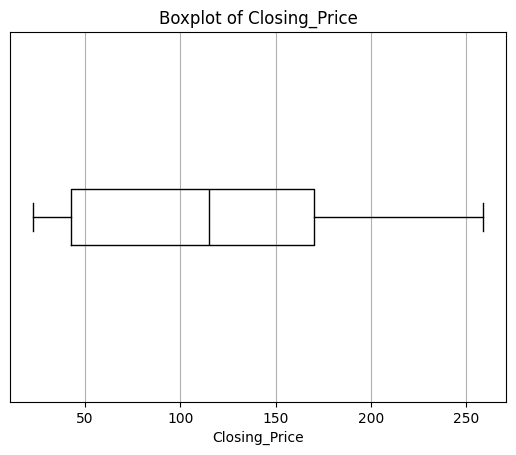

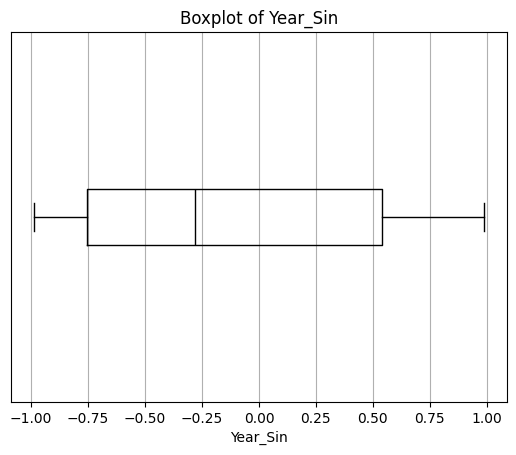

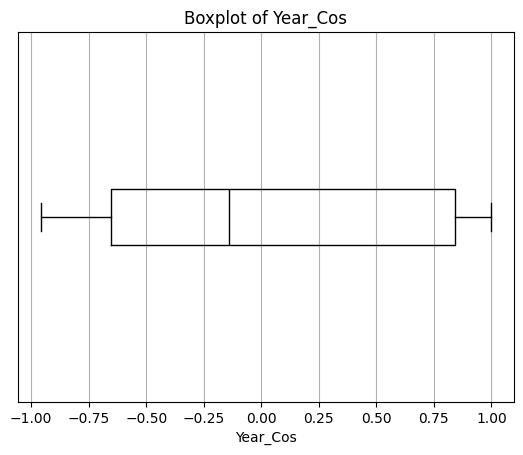

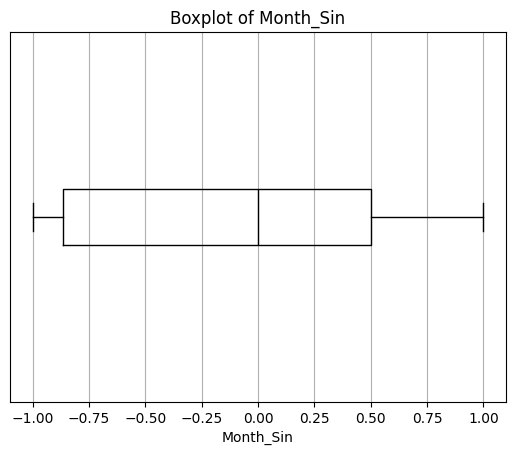

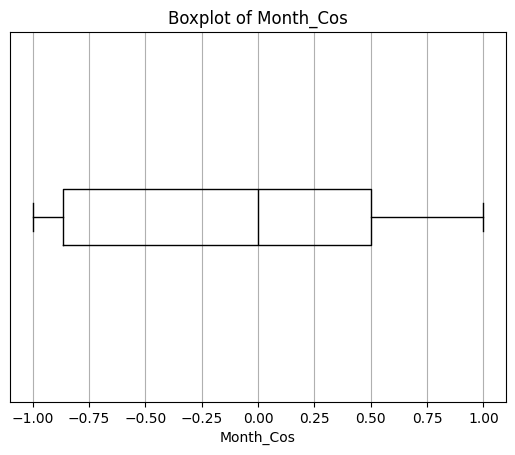

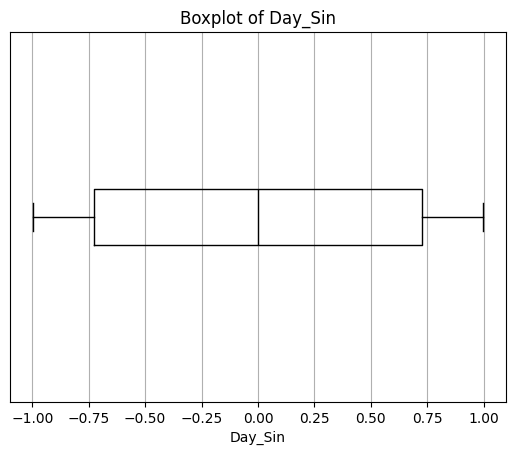

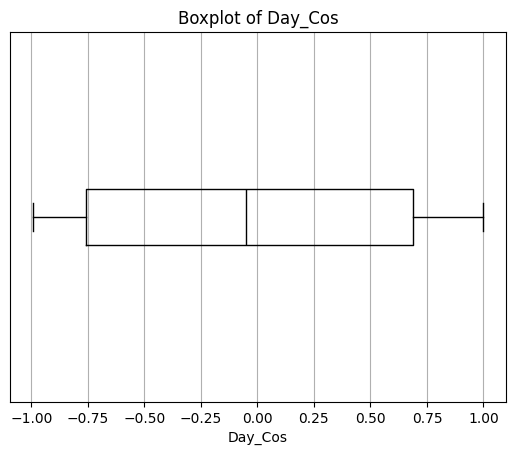

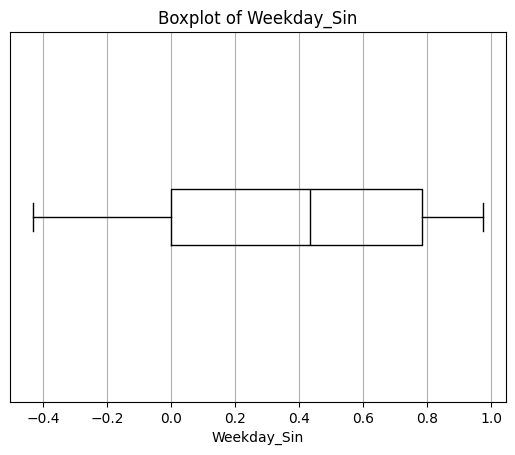

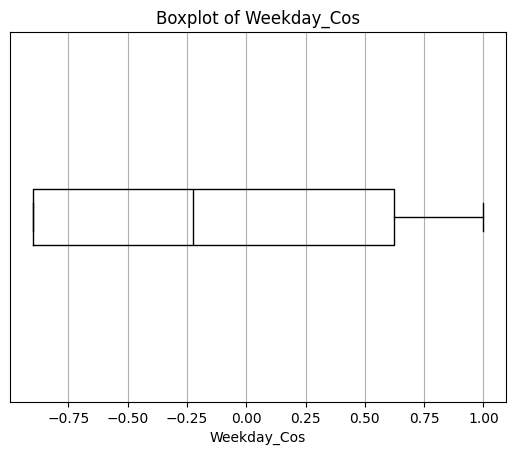

In [83]:
# Statistics of data

for feature in data.columns:
    plot_boxplot_of_feature(data, feature)


In [ ]:
import torch
from torch.nn import RNN, Linear, Module, MSELoss, Parameter
from torch.utils.data import DataLoader, TensorDataset
from torch import tensor, float32
from torch.optim import SGD
from sklearn.preprocessing import StandardScaler

In [ ]:
class ElmanRNN(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.W_h = Linear(input_size, hidden_size, bias=False)
        self.U_h = Linear(hidden_size, hidden_size, bias=True)
        self.b_h = Parameter(torch.zeros(hidden_size))

        self.W_y = Linear(hidden_size, output_size, bias=True)
        self.b_y = Parameter(torch.zeros(output_size))
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        device = x.device

        h_t = torch.zeros(batch_size, self.hidden_size).to(device)

        for t in range(seq_len):
            h_t = torch.tanh(self.W_h(x[:, t, :]) + self.U_h(h_t) + self.b_h)

        y_t = self.W_y(h_t) + self.b_y

        return y_t

In [ ]:
class JordanRNN(Module):
    def __init__(self, input_size, hidden_size, output_size, state_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.state_size = state_size

        self.W_h = Linear(input_size, hidden_size, bias=False)
        self.U_h = Linear(self.state_size, hidden_size, bias=False)
        self.b_h = Parameter(torch.zeros(hidden_size))

        self.W_y = Linear(hidden_size, output_size, bias=False)
        self.b_y = Parameter(torch.zeros(output_size))

        self.W_s = Linear(self.state_size, state_size, bias=False)
        self.W_sy = Linear(output_size, state_size, bias=False)
        self.b_s = Parameter(torch.zeros(state_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        device = x.device

        s_t = torch.zeros(batch_size, self.state_size, device=device)
        y_prev = torch.zeros(batch_size, self.output_size, device=device)

        for t in range(seq_len):
            h_t = torch.tanh(self.W_h(x[:, t, :]) + self.U_h(s_t) + self.b_h)
            y_t = self.W_y(h_t) + self.b_y
            s_prev = s_t
            s_t = torch.tanh(self.W_s(s_prev) + self.W_sy(y_prev) + self.b_s)
            y_prev = y_t

        return y_t

In [ ]:
# Elman network

# https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html

class ElmanRNN(Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.rnn = RNN(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       nonlinearity='tanh',
                       bias=True,
                       batch_first=True,
                       dropout=0.0,
                       bidirectional=False)
        self.fc = Linear(hidden_size, output_size)

    def forward(self, x):
        # All hidden states + last hidden state (h_{n-1})
        out, h_n = self.rnn(x)
        # Sequence to one task, take only last hidden state
        out = self.fc(out[:, -1, :])
        return out

def training(model, data, num_epochs=25, batch_size=16, learning_rate=0.002, hidden_layer_size=32, target_feature_name=None):
    # Prepare data for training using blocked cross validation

    X = data.drop(columns=[target_feature_name]).values
    y = data[target_feature_name].values

    input_shape = X.shape[1]
    output_shape = 1

    print(X.shape)
    print(y.shape)

    X_sequences, y_sequences = create_sequences(X, y, sequence_length=64)

    print(X_sequences.shape)
    print(y_sequences.shape)

    split = TimeSeriesSplit(n_splits=8)

    split_number = 1

    for train_indices, validation_indices in split.split(X_sequences):
        test_losses = []
        validation_losses = []
        
        print(f'Train indices from {train_indices[0]} to {train_indices[-1]} and validation indices from {validation_indices[0]} to {validation_indices[-1]}')

        X_train, X_validation = X_sequences[train_indices], X_sequences[validation_indices]
        y_train, y_validation = y_sequences[train_indices], y_sequences[validation_indices]

        # Scale data

        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train.reshape(-1, input_shape)).reshape(X_train.shape)
        X_validation = scaler_X.transform(X_validation.reshape(-1, input_shape)).reshape(X_validation.shape)

        # Convert to tensors
        X_train_tensor = tensor(X_train, dtype=float32)
        y_train_tensor = tensor(y_train, dtype=float32).view(-1, 1)
        X_validation_tensor = tensor(X_validation, dtype=float32)
        y_validation_tensor = tensor(y_validation, dtype=float32).view(-1, 1)

        # Create datasets and dataloaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        model = model
        model.input_shape = input_shape
        model.hidden_layer_size = hidden_layer_size
        model.output_shape = output_shape

        loss_function = MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            # Training of model

            model.train()
            epoch_train_loss = 0
            for i, (inputs, targets) in enumerate(train_loader):
                # Grads reset
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            # Validation of model

            model.eval()
            epoch_validation_loss = 0
            with torch.no_grad():
                for i, (inputs, targets) in enumerate(validation_loader):
                    outputs = model(inputs)
                    loss = loss_function(outputs, targets)
                    epoch_validation_loss += loss.item()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Loss: {epoch_train_loss / len(train_loader):.4f}, '
                f'Validation Loss: {epoch_validation_loss / len(validation_loader):.4f}')
            
            test_losses.append(epoch_train_loss / len(train_loader))
            validation_losses.append(epoch_validation_loss / len(validation_loader))

        plot_test_versus_validation(test_losses,
                                    validation_losses,
                                    f'../images/elman_hidden32_test_vs_val_fold{split_number}.pdf',
                                    title=f'Elman RNN Hidden Size 32: Fold {split_number} Test vs. Validation Performance')

        split_number += 1


In [ ]:
training(model=ElmanRNN(input_size=8, hidden_size=32, output_size=1), data=data, target_feature_name='ClosingPrice')

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/25], Loss: 48375.5768, Validation Loss: 32412.7840
Epoch [2/25], Loss: 47705.0085, Validation Loss: 31632.5718
Epoch [3/25], Loss: 46841.3177, Validation Loss: 31001.5591
Epoch [4/25], Loss: 46127.4056, Validation Loss: 30453.9517
Epoch [5/25], Loss: 45483.8844, Validation Loss: 29948.1911
Epoch [6/25], Loss: 44881.3039, Validation Loss: 29469.7798
Epoch [7/25], Loss: 44306.3031, Validation Loss: 29010.7607
Epoch [8/25], Loss: 43751.2737, Validation Loss: 28566.4121
Epoch [9/25], Loss: 43211.6361, Validation Loss: 28133.8147
Epoch [10/25], Loss: 42684.4888, Validation Loss: 27711.0540
Epoch [11/25], Loss: 42167.8927, Validation Loss: 27296.8145
Epoch [12/25], Loss: 41660.4940, Validation Loss: 26890.1504
Epoch [13/25], Loss: 41161.2957, Validation Loss: 26490.3551
Epoch [14/25], Loss: 40669.5526, Validation Loss: 26096.8902
Epoch [15/25], Loss: 40184.6859, Validation Loss

KeyboardInterrupt: 

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/25], Loss: 48506.0803, Validation Loss: 32585.2011
Epoch [2/25], Loss: 48303.0629, Validation Loss: 32263.4235
Epoch [3/25], Loss: 47566.1803, Validation Loss: 31592.6122
Epoch [4/25], Loss: 46721.5098, Validation Loss: 30913.9360
Epoch [5/25], Loss: 45925.4478, Validation Loss: 30266.7682
Epoch [6/25], Loss: 45175.8400, Validation Loss: 29671.1012
Epoch [7/25], Loss: 44480.2504, Validation Loss: 29120.8984
Epoch [8/25], Loss: 43829.1702, Validation Loss: 28604.1133
Epoch [9/25], Loss: 43211.3541, Validation Loss: 28112.3216
Epoch [10/25], Loss: 42619.1714, Validation Loss: 27640.1548
Epoch [11/25], Loss: 42047.4973, Validation Loss: 27184.0036
Epoch [12/25], Loss: 41492.7719, Validation Loss: 26741.3147
Epoch [13/25], Loss: 40952.4357, Validation Loss: 26310.2240
Epoch [14/25], Loss: 40424.5892, Validation Loss: 25889.3352
Epoch [15/25], Loss: 39907.7910, Validation Loss

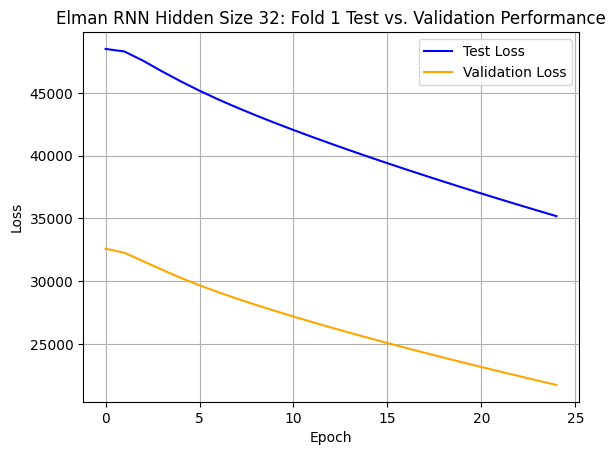

Train indices from 0 to 546 and validation indices from 547 to 818
Epoch [1/25], Loss: 28030.9574, Validation Loss: 13458.3062
Epoch [2/25], Loss: 27301.6562, Validation Loss: 12945.9643
Epoch [3/25], Loss: 26579.0476, Validation Loss: 12445.9947
Epoch [4/25], Loss: 25867.3582, Validation Loss: 11958.0789
Epoch [5/25], Loss: 25168.5408, Validation Loss: 11482.5680
Epoch [6/25], Loss: 24483.2453, Validation Loss: 11019.5591
Epoch [7/25], Loss: 23811.6766, Validation Loss: 10569.0185
Epoch [8/25], Loss: 23153.8580, Validation Loss: 10130.8461
Epoch [9/25], Loss: 22509.7210, Validation Loss: 9704.9077
Epoch [10/25], Loss: 21879.1527, Validation Loss: 9291.0484
Epoch [11/25], Loss: 21262.0099, Validation Loss: 8889.0996
Epoch [12/25], Loss: 20658.1337, Validation Loss: 8498.8861
Epoch [13/25], Loss: 20067.3556, Validation Loss: 8120.2295
Epoch [14/25], Loss: 19489.5008, Validation Loss: 7752.9485
Epoch [15/25], Loss: 18924.3899, Validation Loss: 7396.8595
Epoch [16/25], Loss: 18371.8441, V

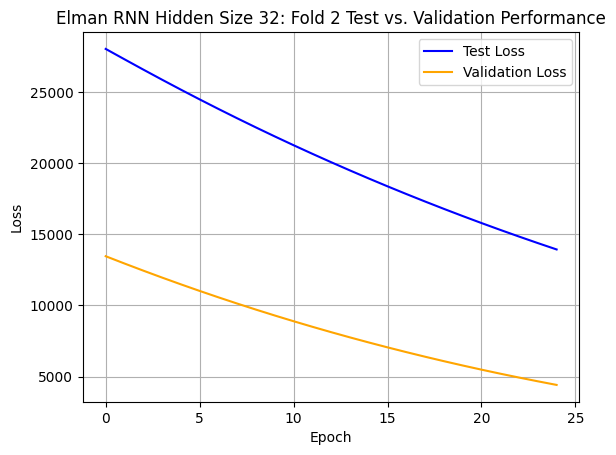

Train indices from 0 to 818 and validation indices from 819 to 1090
Epoch [1/25], Loss: 10373.2819, Validation Loss: 3650.2068
Epoch [2/25], Loss: 9806.7679, Validation Loss: 3307.0984
Epoch [3/25], Loss: 9244.7627, Validation Loss: 2981.8928
Epoch [4/25], Loss: 8703.3839, Validation Loss: 2678.2702
Epoch [5/25], Loss: 8186.5960, Validation Loss: 2396.8271
Epoch [6/25], Loss: 7695.2722, Validation Loss: 2137.2923
Epoch [7/25], Loss: 7229.3220, Validation Loss: 1899.0602
Epoch [8/25], Loss: 6788.2597, Validation Loss: 1681.3711
Epoch [9/25], Loss: 6371.4142, Validation Loss: 1483.3968
Epoch [10/25], Loss: 5978.0199, Validation Loss: 1304.2720
Epoch [11/25], Loss: 5607.2633, Validation Loss: 1143.1253
Epoch [12/25], Loss: 5258.3221, Validation Loss: 999.0747
Epoch [13/25], Loss: 4930.3482, Validation Loss: 871.2486
Epoch [14/25], Loss: 4622.5009, Validation Loss: 758.7772
Epoch [15/25], Loss: 4333.9376, Validation Loss: 660.8068
Epoch [16/25], Loss: 4063.8283, Validation Loss: 576.4962
E

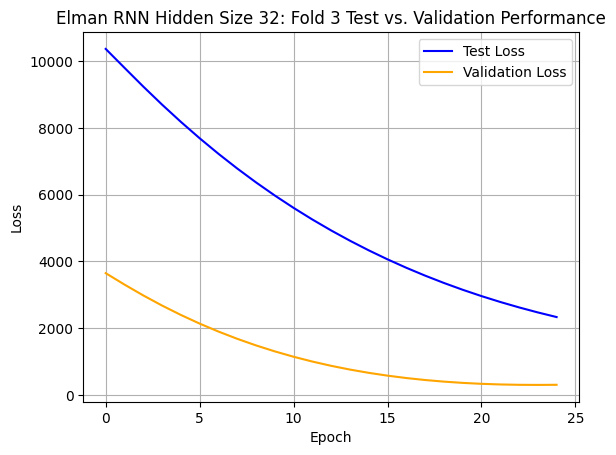

Train indices from 0 to 1090 and validation indices from 1091 to 1362
Epoch [1/25], Loss: 1727.7493, Validation Loss: 3153.6036
Epoch [2/25], Loss: 1628.7584, Validation Loss: 3380.1775
Epoch [3/25], Loss: 1537.0665, Validation Loss: 3607.9312
Epoch [4/25], Loss: 1457.7175, Validation Loss: 3828.0626
Epoch [5/25], Loss: 1391.3551, Validation Loss: 4036.9409
Epoch [6/25], Loss: 1336.6556, Validation Loss: 4227.2367


KeyboardInterrupt: 

In [38]:
training(model=JordanRNN(input_size=8, hidden_size=32, output_size=1, state_size=16), data=data, target_feature_name='ClosingPrice')